# MLP

Coding. Use one neuron. Gudenas style test. Try all K-mers and subset of K-mers.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 15:43:49.194818
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization
from sklearn.preprocessing import StandardScaler

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=5
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 15:44:01.942942
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-20 15:44:01.951653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 15:44:02.127932
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-20 15:44:05.336829


## Train and validate with all K-mer counts

splitting
2022-10-20 15:44:05.365870
Train sizes 12019 12019
Valid sizes 2795 2795
scaling
2022-10-20 15:44:05.522192
Thresholds (-1.266972910885237, 1.1401767974371442)
Train set ones/size 5469 / 12019
Valid set ones/size 1418 / 2795
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-20 15:44:05.636996
Epoch 1/5
376/376 [==============================] - 1s 2ms/step - loss: 0.5175 - accuracy: 0.7355
Epoch 2/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4355 - accuracy: 0.7972
Epoch 3/5
376/376 [==============================] - 1s 2ms/step - loss: 0.4138 - accuracy: 0.8179
Epoch 4/5
376/376 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8299
Epoch 5/5
376/376 [==============================] - 1s 2ms/step - loss: 0.3883 - accuracy: 0.8390


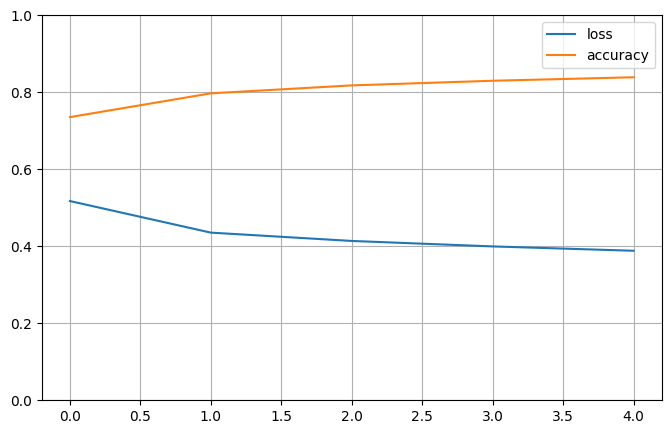

Compute valiation accuracy
2022-10-20 15:44:09.999024
accuracy: 87.98%
2022-10-20 15:44:10.281752


In [8]:
print('splitting')
print(datetime.now())
data_partitions = splitter.get_train_valid_partitions(universe)
one_partition =data_partitions[0]
train_genes,valid_genes = one_partition[0],one_partition[1]
thresholds = splitter.choose_thresholds(train_genes,'one_z')
X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholds)
X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholds)
print('Train sizes',len(X_train),len(y_train))
print('Valid sizes',len(X_valid),len(y_valid))

print('scaling')
print(datetime.now())
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

print('Thresholds',thresholds)
print('Train set ones/size',
      np.count_nonzero(y_train),'/',len(y_train))
print('Valid set ones/size',
      np.count_nonzero(y_valid),'/',len(y_valid))

print("BUILD MODEL")
model=build_model()

print("FIT")
print(datetime.now())
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
        epochs=EPOCHS, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
        #validation_data=(X_valid,y_valid) )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

print("Compute valiation accuracy")
print(datetime.now())
scores = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(datetime.now())

In [9]:
# https://www.tensorflow.org/guide/variable
w=model.trainable_weights[0].numpy()  # weights
b=model.trainable_weights[1].numpy()  # bias
print('bias',b)
print(len(w),'weights min=',min(w),'max=',max(w))

bias [-1.0112555]
256 weights min= [-0.24146825] max= [0.23666012]


In [10]:
def distance(a,b):
    ss = 0
    dim = len(a)
    for i in range(dim):
        ai = a[i]
        bi = b[i]
        df = ai-bi
        sq = df**2
        ss += sq
    return np.sqrt(ss)

In [11]:
distance(X_train[0],X_train[0])

0.0

In [12]:
print(len(X_valid),len(X_train))


2795 12019


In [26]:
print(datetime.now())
valid_index=0
COUNTS=[0,0,0,0,0]
print(COUNTS)
tick = 0
tock = 300
for valid_vec in X_valid:
    train_index=0
    for train_vec in X_train:
        dist = distance(valid_vec,train_vec)
        if dist<=4:
            if dist<0.2:
                print(valid_index,valid_ids[valid_index],
                      train_index,train_ids[train_index])
                COUNTS[0] += 1
            elif dist<=1:
                COUNTS[1] += 1
            elif dist<=2:
                COUNTS[2] += 1
            elif dist<=3:
                COUNTS[3] += 1
            elif dist<=4:
                COUNTS[4] += 1
        train_index += 1
    tick += 1        
    if tick>=tock:
        print(datetime.now())
        print(valid_index,COUNTS)
        tick = 0
    valid_index += 1
print(COUNTS)
print(datetime.now())

2022-10-20 17:50:14.696403
[0, 0, 0, 0, 0]
2022-10-20 17:57:40.868524
299 [0, 127, 2458, 25056, 110572]
2022-10-20 18:05:01.037764
599 [0, 191, 5359, 52174, 239240]
2022-10-20 18:12:38.256005
899 [0, 410, 8337, 79308, 354437]
2022-10-20 18:20:21.865681
1199 [0, 465, 8615, 94337, 471771]
1482 ('ENSG00000175279', 'ENST00000309048.8') 6443 ('ENSG00000251503', 'ENST00000602787.6')
1483 ('ENSG00000175279', 'ENST00000462462.1') 6445 ('ENSG00000251503', 'ENST00000465026.1')
2022-10-20 18:27:42.417009
1499 [2, 483, 9406, 114706, 583295]
2022-10-20 18:35:03.765030
1799 [2, 483, 9909, 142227, 709582]
2022-10-20 18:42:23.588229
2099 [2, 516, 12820, 167799, 837188]
2022-10-20 18:49:45.804818
2399 [2, 713, 17614, 197296, 952437]
2022-10-20 18:57:16.920572
2699 [2, 773, 19390, 216284, 1028332]
[2, 795, 20106, 222879, 1047969]
2022-10-20 18:59:36.715283


In [13]:
print(datetime.now())

2022-10-20 15:44:10.409497


This pair has dist<0.2

Gene: CENPS ENSG00000175279 Description centromere protein S [Source:HGNC Symbol;Acc:HGNC:23163] Chromosome 1: 10,430,433-10,442,808 forward strand. GRCh38:CM000663.2

Gene: CENPS-CORT ENSG00000251503DescriptionCENPS-CORT readthrough [Source:HGNC Symbol;Acc:HGNC:38843] Chromosome 1: 10,430,102-10,452,153 forward strand. GRCh38:CM000663.2

It is encouraging that our distance metric found two obviously-related genes.